# Fraud Detector - Model Training and Detector Creation

---

## Setup

Create S3 bucket and upload related training data for model training.

## Implementation

Create the resoures, model and detector with boto3 python SDK

The the data set is [project_1_data](./project_1_newaccounts_100k.csv).

#### Environment Setup

In [1]:
!pip install -U pip
!pip install boto3

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (20.2.3)


In [2]:
!pip show boto3

Name: boto3
Version: 1.14.60
Summary: The AWS SDK for Python
Home-page: https://github.com/boto/boto3
Author: Amazon Web Services
Author-email: UNKNOWN
License: Apache License 2.0
Location: /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages
Requires: botocore, jmespath, s3transfer
Required-by: sagemaker, s3fs


In [3]:
# Setup proper Role and copy Role ARN in below
DATA_ACCESS_ROLE_ARN = ""

### S3 bucket setup

In [4]:
import boto3
from datetime import datetime
import time

In [5]:
session = boto3.Session()
region = session.region_name
account_id = session.client('sts').get_caller_identity().get('Account')
bucket_name = f"{account_id}-fraud-detector-lab-{region}"
s3 = boto3.client('s3')
try:
    if ("us-east-1" == region):
        s3.create_bucket(Bucket=bucket_name)
    else:
        s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={
            'LocationConstraint': region})
except:
    pass


In [6]:
# Upload data file into S3 bucket
s3.upload_file('./project_1_newaccounts_100k.csv', bucket_name, 'project_1_newaccounts_100k.csv')
s3.upload_file('./project_1_newaccounts_5k.csv', bucket_name, 'project_1_newaccounts_5k.csv')

In [7]:
train_data_uri = f"s3://{bucket_name}/project_1_newaccounts_100k.csv"
train_data_uri

's3://593380422482-fraud-detector-lab-ap-southeast-2/project_1_newaccounts_100k.csv'

In [8]:
evaluation_data_uri = f"s3://{bucket_name}/project_1_newaccounts_5k.csv"
evaluation_data_file = "project_1_newaccounts_5k.csv"

### Create Fraud Detector Resources (Variable, label, event and event type)

In [9]:
# -- fraud detector client --
fraud_detector = boto3.client('frauddetector',)

# -- use this to append to files 
suffix   = datetime.now().strftime("%Y%m%d")

#### Labels Creation
A label classifies an event as fraudulent or legitimate. Once you have created a label, add the label to the event type by calling the PutEventType API.

In [10]:
# collect existing labels
response = fraud_detector.get_labels()
existing_label_names = [label['name'] for label in response['labels']]

# setup fraudulent and legitimate labels; must match with the actual label value.
LABEL_FRAUD = '1'
LABEL_LEGIT = '0'

if LABEL_FRAUD not in existing_label_names:
    fraud_detector.put_label(
        name = LABEL_FRAUD,
        description = 'label for fraud events'
    )

if LABEL_LEGIT not in existing_label_names:
    fraud_detector.put_label(
        name = LABEL_LEGIT,
        description = 'label for legit events'
    )


In [11]:
# all the labels
response = fraud_detector.get_labels()
response

{'labels': [{'name': 'fraud',
   'description': 'fraudulent event',
   'lastUpdatedTime': '2020-09-22T01:48:28.570Z',
   'createdTime': '2020-09-22T01:48:28.570Z',
   'arn': 'arn:aws:frauddetector:ap-southeast-2:593380422482:label/fraud'},
  {'name': '1',
   'description': 'fraud',
   'lastUpdatedTime': '2020-09-28T23:47:34.721Z',
   'createdTime': '2020-09-28T23:47:34.721Z',
   'arn': 'arn:aws:frauddetector:ap-southeast-2:593380422482:label/1'},
  {'name': '0',
   'description': 'legit',
   'lastUpdatedTime': '2020-09-28T23:47:43.758Z',
   'createdTime': '2020-09-28T23:47:43.758Z',
   'arn': 'arn:aws:frauddetector:ap-southeast-2:593380422482:label/0'},
  {'name': 'legit',
   'description': 'legitimate event',
   'lastUpdatedTime': '2020-09-22T01:48:53.778Z',
   'createdTime': '2020-09-22T01:48:53.778Z',
   'arn': 'arn:aws:frauddetector:ap-southeast-2:593380422482:label/legit'}],
 'ResponseMetadata': {'RequestId': 'e2bcd9dc-89e9-40a5-bc1c-31fc10720b82',
  'HTTPStatusCode': 200,
  'HTTP

#### Variables creation
Variables represent data elements that you want to use in a fraud prediction, such as data from the event that is being evaluated or risk score outputs from Amazon Fraud Detector models or Amazon SageMaker models.



In [61]:
# collect variables
response = fraud_detector.get_variables()
existing_variable_names = [variable['name'] for variable in response['variables']]


# replace with your preferred if needed
VARIABLE_IP_ADDRESS = 'ip_address'
VARIABLE_EMAIL_ADDRESS = 'email_address'
VARIABLE_PHONE_NUMBER = 'phone_number'
VARIABLE_USER_AGENT = 'user_agent'
VARIABLE_CUSTOMER_STATE = 'customer_state'
VARIABLE_CUSTOMER_POSTAL = 'customer_postal'
VARIABLE_CUSTOMER_ADDRESS = 'customer_address'
VARIABLE_CUSTOMER_CITY = 'customer_city'

event_variables = [
    VARIABLE_IP_ADDRESS,
    VARIABLE_EMAIL_ADDRESS,
    VARIABLE_PHONE_NUMBER,
    VARIABLE_USER_AGENT,
    VARIABLE_CUSTOMER_STATE,
    VARIABLE_CUSTOMER_POSTAL,
    VARIABLE_CUSTOMER_ADDRESS,
    VARIABLE_CUSTOMER_CITY
]

#Create variable ip_address
if VARIABLE_IP_ADDRESS not in existing_variable_names:
    fraud_detector.create_variable(
        name = VARIABLE_IP_ADDRESS,
        variableType = 'IP_ADDRESS',
        dataType = 'STRING',
        dataSource = 'EVENT'
    )
    
#Create variable email_address
if VARIABLE_EMAIL_ADDRESS not in existing_variable_names:
    fraud_detector.create_variable(
        name = VARIABLE_EMAIL_ADDRESS,
        variableType = 'EMAIL_ADDRESS',
        dataType = 'STRING',
        dataSource = 'EVENT'
    )
    
#Create variable phone_number
if VARIABLE_PHONE_NUMBER not in existing_variable_names:
    fraud_detector.create_variable(
        name = VARIABLE_PHONE_NUMBER,
        variableType = 'PHONE_NUMBER',
        dataType = 'STRING',
        dataSource = 'EVENT'
    )    
    
#Create variable user_agent
if VARIABLE_USER_AGENT not in existing_variable_names:
    fraud_detector.create_variable(
        name = VARIABLE_USER_AGENT,
        variableType = 'USERAGENT',
        dataType = 'STRING',
        dataSource = 'EVENT'
    )
    
#Create variable customer_state
if VARIABLE_CUSTOMER_STATE not in existing_variable_names:
    fraud_detector.create_variable(
        name = VARIABLE_CUSTOMER_STATE,
        variableType = 'BILLING_STATE',
        dataType = 'STRING',
        dataSource = 'EVENT'
    )    
    
#Create variable customer_postal
if VARIABLE_CUSTOMER_POSTAL not in existing_variable_names:
    fraud_detector.create_variable(
        name = VARIABLE_CUSTOMER_POSTAL,
        variableType = 'BILLING_ZIP',
        dataType = 'STRING',
        dataSource = 'EVENT'
    )    
    
#Create variable customer_address
if VARIABLE_CUSTOMER_ADDRESS not in existing_variable_names:
    fraud_detector.create_variable(
        name = VARIABLE_CUSTOMER_ADDRESS,
        variableType = 'SHIPPING_ADDRESS_L1',
        dataType = 'STRING',
        dataSource = 'EVENT'
    )   
    
#Create variable customer_city
if VARIABLE_CUSTOMER_CITY not in existing_variable_names:
    fraud_detector.create_variable(
        name = VARIABLE_CUSTOMER_CITY,
        variableType = 'BILLING_CITY',
        dataType = 'STRING',
        dataSource = 'EVENT'
    )    

#### Entity type

An entity represents who is performing the event. As part of a fraud prediction, you can pass the entity ID to indicate the specific entity who performed the event.

An entity type classifies the entity. Example classifications include customer, merchant, or account.

In [13]:
# collect entity types
response = fraud_detector.get_entity_types()
existing_entity_type_names = [entity_type['name'] for entity_type in response['entityTypes']]

# replace with your preferred if needed
ENTITY_TYPE_NAME = "account"

if ENTITY_TYPE_NAME not in existing_entity_type_names:
    fraud_detector.put_entity_type(
        name = ENTITY_TYPE_NAME,
        description = 'Sample account entity type'
    )


#### Event Type

With Amazon Fraud Detector, you generate fraud predictions for events. An event type defines the structure for an individual event sent to Amazon Fraud Detector. Once defined, you can build models and detectors that evaluate the risk for specific event types.

In [62]:
# collect event types
response = fraud_detector.get_event_types()
existing_event_type_names = [event_type['name'] for event_type in response['eventTypes']]

# replace with your preferred if needed
EVENT_TYPE_NAME = "my_new_account_registration"

if EVENT_TYPE_NAME not in existing_event_type_names:
    fraud_detector.put_event_type (
        name = EVENT_TYPE_NAME,
        description='Sample event type',
        eventVariables = event_variables,
        labels = [
            LABEL_LEGIT, 
            LABEL_FRAUD
        ],
        entityTypes = [ 
            ENTITY_TYPE_NAME 
        ]
    )

#### Model
A model version is the term Amazon Fraud Detector uses for a trained fraud detection machine learning model. All steps in the model training process are fully automated including data validation, data transformation, feature engineering, algorithm selection, training, and model optimization. Creating a model requires selecting the model type and specifying the model version configuration. The model type specifies the algorithms and transformations used to build the model.

In [15]:
# Collect model ids
response = fraud_detector.get_models()
existing_model_ids = [ model['modelId'] for model in response['models'] ]

# Create model (which is a container for model version), replace with your preferred if needed
MODEL_ID = "sample_project_x"

if MODEL_ID not in existing_model_ids:
    fraud_detector.create_model (
        modelId = MODEL_ID,
        eventTypeName = EVENT_TYPE_NAME,
        modelType = 'ONLINE_FRAUD_INSIGHTS'
    )

In [ ]:
# Create model version, which start the model training; 
# PLEASE DON'T RUN IT MULTIPLE TIMES UNLESS IT'S NECESSARY!
# model version creation (model training) takes approx. 50-60mins with existing sample data - the 100k one.
response = fraud_detector.create_model_version (
    modelId = MODEL_ID,
    modelType = 'ONLINE_FRAUD_INSIGHTS',
    trainingDataSource = 'EXTERNAL_EVENTS',
    trainingDataSchema = {
        'modelVariables' : [
            VARIABLE_IP_ADDRESS,
            VARIABLE_EMAIL_ADDRESS,
            VARIABLE_PHONE_NUMBER,
            VARIABLE_USER_AGENT,
            VARIABLE_CUSTOMER_STATE,
            VARIABLE_CUSTOMER_POSTAL,
            VARIABLE_CUSTOMER_CITY
        ],
        'labelSchema' : {
            'labelMapper' : {
                'FRAUD' : [ LABEL_FRAUD ],
                'LEGIT' : [ LABEL_LEGIT ]
            }
        }
    }, 
    externalEventsDetail = {
        'dataLocation' : train_data_uri,
        'dataAccessRoleArn' : DATA_ACCESS_ROLE_ARN
    }
)
modelVersionNumber = response['modelVersionNumber']

In [ ]:
def check_model_version_status(target_status):
    print(f"to check model version status till [{target_status}]")
    while True:
        response = fraud_detector.get_model_version(
            modelId = MODEL_ID,
            modelType = 'ONLINE_FRAUD_INSIGHTS',
            modelVersionNumber = modelVersionNumber
        )
        print(f"Model version {MODEL_ID}:{modelVersionNumber} status check: {response['status']}")
        if target_status == response['status']:
            break
        else:
            time.sleep(60)    

In [ ]:
%%time

# checking model version training progress
check_model_version_status('TRAINING_COMPLETE')

In [ ]:
# activate/deploy model version
fraud_detector.update_model_version_status (
    modelId = MODEL_ID,
    modelType = 'ONLINE_FRAUD_INSIGHTS',
    modelVersionNumber = modelVersionNumber,
    status = 'ACTIVE'
)

In [ ]:
%%time

check_model_version_status('ACTIVE')

#### Detector 
A detector contains the detection logic, such as the models and rules, for a particular event that you want to evaluate for fraud. Each detector can evaluate one event type.

A detector can have multiple versions, with each version having a status of DRAFT, ACTIVE, or INACTIVE. Only one detector version can be in ACTIVE status at a time.

In [16]:
# Collect existing detector ids
response = fraud_detector.get_detectors()
existing_detector_ids = [detector['detectorId'] for detector in response['detectors']]

# replace with your preferred if needed
DETECTOR_ID = "my_new_account_fraud_detector"

# Detector is a container for detector versions.
if DETECTOR_ID not in existing_detector_ids:
    fraudDetector.put_detector (
        detectorId = DETECTOR_ID,
        eventTypeName = EVENT_TYPE_NAME
    )

##### Create Outcome
An outcome is the result of a fraud prediction. Create an outcome for each possible fraud prediction result. For example, you may want outcomes to represent risk levels (high_risk, medium_risk, and low_risk) or actions (approve, review). Once created, you can add one or more outcomes to a rule. As part of the GetEventPrediction response, Amazon Fraud Detector will return the defined outcomes for any matched rule.

In [17]:
# Collect existing outcomes
response = fraud_detector.get_outcomes()
existing_outcome_names = [ outcome['name'] for outcome in response['outcomes'] ]


OUTCOME_BLOCK = 'block'
OUTCOME_REVIEW = 'review'
OUTCOME_FRICTION = 'friction'
OUTCOME_APPROVE = 'approve'

if OUTCOME_BLOCK not in existing_outcome_names:
    fraud_detector.put_outcome(
        name = OUTCOME_BLOCK,
        description = 'this outcome blocks the event'
    )

if OUTCOME_REVIEW not in existing_outcome_names:
    fraud_detector.put_outcome(
        name = OUTCOME_REVIEW,
        description = 'this outcome sidelines event for review'
    )

if OUTCOME_FRICTION not in existing_outcome_names:
    fraud_detector.put_outcome(
        name = OUTCOME_FRICTION,
        description = 'this outcome frictions the event'
    )

if OUTCOME_APPROVE not in existing_outcome_names:
    fraud_detector.put_outcome(
        name = OUTCOME_APPROVE,
        description = 'this outcome approves the event'
    )

##### Create Rules
A rule is a condition that tells Amazon Fraud Detector how to interpret variable values during a fraud prediction. A rule consists of one or more variables, a logic expression, and one or more outcomes. A detector must have at least one associated rule. Rules in a detector are evaluated as part of a fraud prediction.

In [18]:
modelVersionNumber = "1.0"

In [19]:
response = fraud_detector.get_rules(detectorId = DETECTOR_ID)
response

{'ruleDetails': [{'ruleId': 'rule_review',
   'detectorId': 'my_new_account_fraud_detector',
   'ruleVersion': '1',
   'expression': '$sample_project_x_insightscore >= 855 and $sample_project_x_insightscore < 950',
   'language': 'DETECTORPL',
   'outcomes': ['review'],
   'lastUpdatedTime': '2020-09-30T06:00:26.215Z',
   'createdTime': '2020-09-30T06:00:26.215Z',
   'arn': 'arn:aws:frauddetector:ap-southeast-2:593380422482:rule/my_new_account_fraud_detector/rule_review/1'},
  {'ruleId': 'rule_friction',
   'detectorId': 'my_new_account_fraud_detector',
   'ruleVersion': '1',
   'expression': '$sample_project_x_insightscore >= 600 and $sample_project_x_insightscore < 855',
   'language': 'DETECTORPL',
   'outcomes': ['friction'],
   'lastUpdatedTime': '2020-09-30T06:00:26.295Z',
   'createdTime': '2020-09-30T06:00:26.295Z',
   'arn': 'arn:aws:frauddetector:ap-southeast-2:593380422482:rule/my_new_account_fraud_detector/rule_friction/1'},
  {'ruleId': 'rule_block',
   'detectorId': 'my_n

In [93]:
class Rule:
    
    def __init__(self, id, detector_id, expression, outcomes):
        self.id = id
        self.detector_id = detector_id
        self.expression = expression
        self.outcomes = outcomes
        self.rule_version = None
    
    def may_create_rule_and_collect_rule_version(self, fraud_detector):
        """
        Assume the rule comparison is based on rule id and related expression only. 
        """
        response = fraud_detector.get_rules(
            ruleId = self.id,
            detectorId = self.detector_id
        )
        to_create_rule = ( not response['ruleDetails'] ) or ( response['ruleDetails'][0]['expression'] != self.expression )
        if not response['ruleDetails']:
            result = fraud_detector.create_rule(
                ruleId = self.id,
                detectorId = self.detector_id,
                expression = self.expression,
                language = 'DETECTORPL',
                outcomes = self.outcomes
            )
            self.rule_version = result['rule']['ruleVersion']
        elif response['ruleDetails'][0]['expression'] != self.expression:
            result = fraud_detector.update_rule_version(
                rule={
                    'detectorId': self.detector_id,
                    'ruleId': self.id,
                    'ruleVersion': response['ruleDetails'][0]['ruleVersion']
                },
                expression = self.expression,
                language = 'DETECTORPL',
                outcomes = self.outcomes
            )
            self.rule_version = result['rule']['ruleVersion']
        else:
            self.rule_version = response['ruleDetails'][0]['ruleVersion']

    def to_detector_version_output(self):
        """
        An rule output for detector version creation.
        """
        return {
            'detectorId' : self.detector_id,
            'ruleId' : self.id,
            'ruleVersion' : self.rule_version
        }

In [90]:
RULE_ID_BLOCK = 'rule_block'
RULE_ID_REVIEW = 'rule_review'
RULE_ID_FRICTION = 'rule_friction'
RULE_ID_APPROVE = 'rule_approve'

# model insightscore expression is base on "{model_name}_insightscore"
rule_block = Rule(RULE_ID_BLOCK, DETECTOR_ID, f"${MODEL_ID}_insightscore >= 950", [ OUTCOME_BLOCK ] )
rule_review = Rule(RULE_ID_REVIEW, DETECTOR_ID, f"${MODEL_ID}_insightscore >= 855 and ${MODEL_ID}_insightscore < 950", [ OUTCOME_REVIEW ] )
rule_friction = Rule(RULE_ID_FRICTION, DETECTOR_ID, f"${MODEL_ID}_insightscore >= 600 and ${MODEL_ID}_insightscore < 855", [ OUTCOME_FRICTION ] )
rule_approve = Rule(RULE_ID_APPROVE, DETECTOR_ID, f"${MODEL_ID}_insightscore < 600", [ OUTCOME_APPROVE ] )

rule_block.may_create_rule_and_collect_rule_version(fraud_detector)
rule_review.may_create_rule_and_collect_rule_version(fraud_detector)
rule_friction.may_create_rule_and_collect_rule_version(fraud_detector)
rule_approve.may_create_rule_and_collect_rule_version(fraud_detector)


##### Create Detector Version
A detector version defines the specific models and rules that will be run as part of the GetEventPrediction request. You can add any of the rules defined within a detector to the detector version. You can also add any model trained on the evaluated event type.

Each detector version has a status of DRAFT, ACTIVE, or INACTIVE. Only one detector version can be in ACTIVE status at a time. During the GetEventPrediction request, Amazon Fraud Detector will use the ACTIVE detector if no DetectorVersion is specified.

In [54]:
def create_detector_version(fraud_detector, detectorId, rule_arr, model_id, model_version_number, ruleExecutionMode = 'FIRST_MATCHED'):
    rules = [rule.to_detector_version_output() for rule in rule_arr]
    response = fraud_detector.create_detector_version(
        detectorId = detectorId,
        rules = rules,
        modelVersions = [{
            'modelId' : model_id,
            'modelType': 'ONLINE_FRAUD_INSIGHTS',
            'modelVersionNumber' : model_version_number
        }],
        ruleExecutionMode = ruleExecutionMode
    )

    return response['detectorVersionId']

def activate_detector_version(fraud_detector, detector_id, detector_version_id):
    response = fraud_detector.update_detector_version_status(
        detectorId = detector_id,
        detectorVersionId = detector_version_id,
        status = 'ACTIVE'
    )
    return response['ResponseMetadata']['HTTPStatusCode'] == 200

In [55]:
# create detector version
detector_version_id = create_detector_version(
    fraud_detector, 
    DETECTOR_ID, 
    [rule_block, rule_review, rule_friction, rule_approve],
    MODEL_ID,
    modelVersionNumber
)
result = activate_detector_version(
    fraud_detector, 
    DETECTOR_ID,
    detector_version_id
)

##### Inference
-----
The following applies the get_event_prediction endpoint to your recrods in your data frame.    

<i> Note: this uses the Dask backend to parallelize the prediction calls. </i>

<div class="alert alert-info"> 💡 <strong> get_event_prediction </strong>

To specify the number of records to score you change the record_count to a specific number (e.g., if you want to just predict on say 100 records). By default it assumes you want to apply predictions to the whole dataset. Once completed convert json to a pandas dataframe, and appends any existing labels, and analyze based on score threshold for a particular false positive rate (FPR).

</div>

this is all you need to run predictions: 

```python

client.get_event_prediction(detectorId=DETECTOR_NAME, 
                            detectorVersionId=DETECTOR_VERSION,
                            eventId = '222222',
                            eventTypeName = EVENT_TYPE,
                            eventTimestamp = '2020-07-27 12:01:01', 
                            entities = [{'entityType': ENTITY_TYPE, 'entityId':'11111'}],
                            eventVariables=  record)
```

Example of what a record would look like: 

```python
record = [{'order_amt': '8036.0',
  'ip_address': '192.18.59.93',
  'email_address': 'synth_george_hayduke@example.com',
  'cc_bin': '42785',
  'billing_postal': '17740-2745',
  'shipping_postal': '20950-6945',
  'customer_name': 'Geroge Hayduke'}]
```

In [74]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
import numpy as np
np.seterr(divide='ignore', invalid='ignore')


import pandas as pd
import uuid 
from datetime import datetime

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# -- dask for parallelism -- 
import dask 

# -- standard stuff -- 
import time
from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plt

In [82]:
@dask.delayed
def _predict(fraud_detector, record, detector_id, detector_version_id, model_id, event_type_name, entity_type_name, event_timestamp):
    eventId = uuid.uuid1()
    try:
        pred = fraud_detector.get_event_prediction(
            detectorId = detector_id, 
            detectorVersionId = detector_version_id,
            eventId = str(eventId),
            eventTypeName = event_type_name,
            eventTimestamp = event_timestamp, 
            entities = [{'entityType': entity_type_name, 'entityId':str(eventId.int)}],
            eventVariables=  record) 
        
        record["score"]   = pred['modelScores'][0]['scores']["{0}_insightscore".format(model_id)]
        record["outcomes"]= pred['ruleResults'][0]['outcomes']
        return record
    
    except:
        pred = fraud_detector.get_event_prediction(
            detectorId = detector_id, 
            detectorVersionId = detector_version_id,
            eventId = str(eventId),
            eventTypeName = event_type_name,
            eventTimestamp = event_timestamp, 
            entities = [{'entityType': entity_type_name, 'entityId':str(eventId.int)}],
            eventVariables=  record) 
        record["score"]   = "-999"
        record["outcomes"]= "error"
        return record

def do_predictions(fraud_detector, df, detector_id, detector_version_id, model_id, event_type_name, entity_type_name):
    start = time.time()
    predict_score = []
    event_timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")
    
    predict_data  = df.head(record_count).astype(str).to_dict(orient='records')
    i=0
    for record in predict_data:
        clear_output(wait=True)
        rec = dask.delayed(_predict)(fraud_detector, record, detector_id, detector_version_id, model_id, event_type_name, entity_type_name, event_timestamp)
        predict_score.append(rec)
        i += 1
        print("current progress: ", round((i/record_count)*100,2), "%" )


    predict_recs = dask.compute(*predict_score)

    # Calculate time taken and print results
    time_taken = time.time() - start
    tps = len(predict_recs) / time_taken

    print ('Process took %0.2f seconds' %time_taken)
    print ('Scored %d records' %len(predict_recs))

    return predict_recs

def plot_predictions(predictions, threshold = 950):
    predictions['score_bin'] = pd.cut(predictions['score'],100 ,labels = list(range(0,1000,10)))
    predictions.loc[predictions['score'] >= threshold, 'score_outcome'] = 'predicted fraud'
    predictions.loc[predictions['score'] < threshold, 'score_outcome'] = 'predicted legit'
    ctab = pd.crosstab(predictions['score_bin'], predictions['score_outcome']).reset_index()

    plt.figure(figsize=(20,10))
    plt.bar(ctab['score_bin'], ctab['predicted fraud'], width=7)
    plt.bar(ctab['score_bin'], ctab['predicted legit'], width=7)
    plt.axvline(x = threshold, ls='--', C='red')
    plt.title("Sample Data, Score Distribution")
    plt.text( threshold, 16, f'score >= {threshold}')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.show()    

In [65]:
# Read the evaluation data set
df = pd.read_csv("./project_1_newaccounts_5k.csv")
df['user_agent'] = df['user_agent'].str.slice(start=0, stop=254)
df.head()

,ip_address,email_address,user_agent,customer_city,customer_state,customer_postal,EVENT_TIMESTAMP,customer_name,customer_address,phone_number,EVENT_LABEL
0,84.138.6.238,synth_tmorton@yahoo.com,Mozilla/5.0 (X11; Linux i686) AppleWebKit/535....,Meganstad,LA,32733.0,2020-04-11 17:27:38,Brandon Moran,824 Price Bypass,(555)784 - 5238,0
1,194.147.250.63,synth_oscott@yahoo.com,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_6_4 rv...,Christinaport,MN,34319.0,2020-04-11 17:31:12,Dominic Murray,13515 Ashley Haven Apt. 472,(555)114 - 6133,0
2,192.54.60.50,synth_aoliver@gmail.com,Mozilla/5.0 (iPad; CPU iPad OS 3_1_3 like Mac ...,Donaldfurt,WA,32436.0,2020-04-11 17:46:34,Anthony Abbott,039 Amy Glens,(555)780 - 7652,0
3,169.120.193.154,synth_clewis@gmail.com,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_10_9; ...,Williamburgh,AL,34399.0,2020-04-11 17:48:52,Kimberly Webb,81397 Tom Forge,(555)588 - 4426,0
4,192.175.55.43,synth_katherinedavis@hotmail.com,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_0 ...,East Markland,IL,33690.0,2020-04-11 17:49:23,Renee James,6815 Dawson Estate,(555)785 - 8274,0


In [78]:
# record_count = df.shape[0] # -- override  to run all records in file 
record_count = 100
predict_recs = do_predictions(
    fraud_detector, 
    df[event_variables], 
    DETECTOR_ID, 
    detector_version_id, 
    MODEL_ID, 
    EVENT_TYPE_NAME, 
    ENTITY_TYPE_NAME)
predictions = pd.DataFrame.from_dict(predict_recs, orient='columns')
predictions.head(10)

current progress:  100.0 %
Process took 10.07 seconds
Scored 100 records


,ip_address,email_address,phone_number,user_agent,customer_state,customer_postal,customer_address,customer_city,score,outcomes
0,84.138.6.238,synth_tmorton@yahoo.com,(555)784 - 5238,Mozilla/5.0 (X11; Linux i686) AppleWebKit/535....,LA,32733.0,824 Price Bypass,Meganstad,4.0,[approve]
1,194.147.250.63,synth_oscott@yahoo.com,(555)114 - 6133,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_6_4 rv...,MN,34319.0,13515 Ashley Haven Apt. 472,Christinaport,88.0,[approve]
2,192.54.60.50,synth_aoliver@gmail.com,(555)780 - 7652,Mozilla/5.0 (iPad; CPU iPad OS 3_1_3 like Mac ...,WA,32436.0,039 Amy Glens,Donaldfurt,5.0,[approve]
3,169.120.193.154,synth_clewis@gmail.com,(555)588 - 4426,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_10_9; ...,AL,34399.0,81397 Tom Forge,Williamburgh,966.0,[block]
4,192.175.55.43,synth_katherinedavis@hotmail.com,(555)785 - 8274,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_0 ...,IL,33690.0,6815 Dawson Estate,East Markland,580.0,[approve]
5,192.175.49.125,synth_deborahlevy@gmail.com,(555)361 - 8855,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.7.20) G...,PA,32023.0,49070 Karen Track Suite 173,North Nathanielland,998.0,[block]
6,192.88.47.35,synth_fcampbell@gmail.com,(555)917 - 7063,Mozilla/5.0 (iPod; U; CPU iPhone OS 3_2 like M...,ID,33498.0,6594 Henderson Mills,North Carrie,261.0,[approve]
7,203.132.48.232,synth_paulthompson@yahoo.com,(555)489 - 7438,Mozilla/5.0 (compatible; MSIE 8.0; Windows 98;...,WA,33210.0,196 Leonard Ports,North Russellshire,13.0,[approve]
8,192.52.209.175,synth_rhondamendoza@hotmail.com,(555)825 - 8953,Mozilla/5.0 (Macintosh; U; PPC Mac OS X 10_11_...,LA,34736.0,550 Eric Village Apt. 802,Adamston,154.0,[approve]
9,67.122.117.211,synth_paul53@gmail.com,(555)565 - 8166,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_6;...,WV,32857.0,45987 Hunter Stravenue,Stevenborough,233.0,[approve]


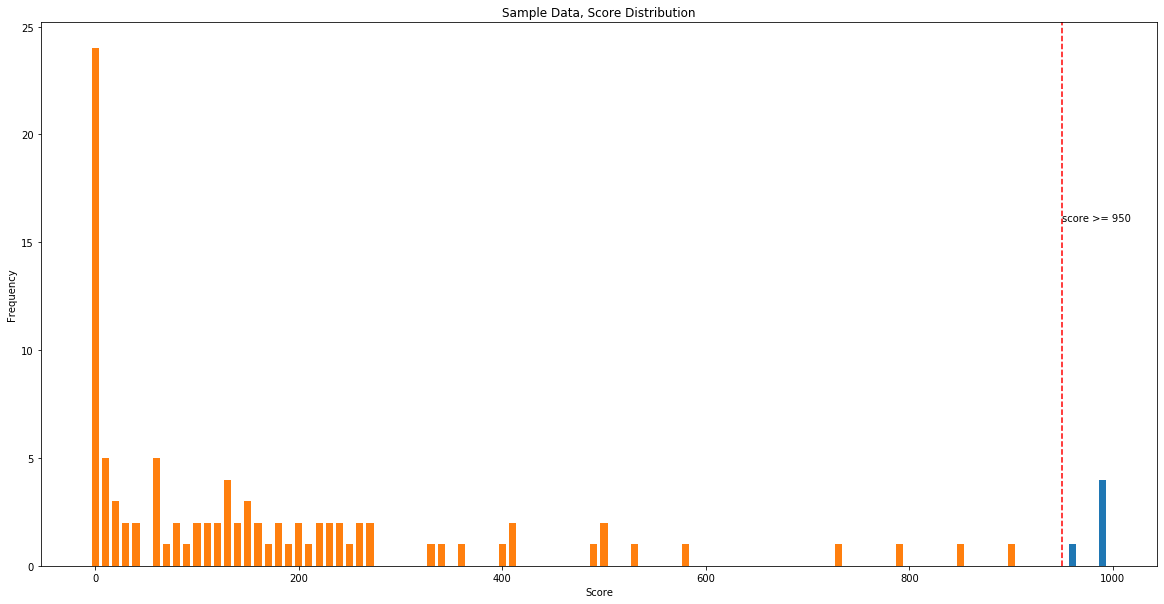

In [83]:
plot_predictions(predictions)

##### Use different threshold

Let's try to do threshold = 985 and plot the predictions

In [94]:
THRESHOLD = 985

# create detector version
rule_block = Rule(RULE_ID_BLOCK, DETECTOR_ID, f"${MODEL_ID}_insightscore >= {THRESHOLD}", [ OUTCOME_BLOCK ] )
rule_block.may_create_rule_and_collect_rule_version(fraud_detector)

rule_review = Rule(RULE_ID_REVIEW, DETECTOR_ID, f"${MODEL_ID}_insightscore >= 855 and ${MODEL_ID}_insightscore < {THRESHOLD}", [ OUTCOME_REVIEW ] )
rule_review.may_create_rule_and_collect_rule_version(fraud_detector)

detector_version_id = create_detector_version(
    fraud_detector, 
    DETECTOR_ID, 
    [rule_block, rule_review, rule_friction, rule_approve],
    MODEL_ID,
    modelVersionNumber
)
result = activate_detector_version(
    fraud_detector, 
    DETECTOR_ID,
    detector_version_id
)

In [97]:
# record_count = df.shape[0] # -- override  to run all records in file 
record_count = 100
predict_recs = do_predictions(
    fraud_detector, 
    df[event_variables], 
    DETECTOR_ID, 
    detector_version_id, 
    MODEL_ID, 
    EVENT_TYPE_NAME, 
    ENTITY_TYPE_NAME)
predictions = pd.DataFrame.from_dict(predict_recs, orient='columns')
predictions.head(10)

current progress:  100.0 %
Process took 10.08 seconds
Scored 100 records


,ip_address,email_address,phone_number,user_agent,customer_state,customer_postal,customer_address,customer_city,score,outcomes
0,84.138.6.238,synth_tmorton@yahoo.com,(555)784 - 5238,Mozilla/5.0 (X11; Linux i686) AppleWebKit/535....,LA,32733.0,824 Price Bypass,Meganstad,4.0,[approve]
1,194.147.250.63,synth_oscott@yahoo.com,(555)114 - 6133,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_6_4 rv...,MN,34319.0,13515 Ashley Haven Apt. 472,Christinaport,90.0,[approve]
2,192.54.60.50,synth_aoliver@gmail.com,(555)780 - 7652,Mozilla/5.0 (iPad; CPU iPad OS 3_1_3 like Mac ...,WA,32436.0,039 Amy Glens,Donaldfurt,5.0,[approve]
3,169.120.193.154,synth_clewis@gmail.com,(555)588 - 4426,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_10_9; ...,AL,34399.0,81397 Tom Forge,Williamburgh,966.0,[review]
4,192.175.55.43,synth_katherinedavis@hotmail.com,(555)785 - 8274,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_0 ...,IL,33690.0,6815 Dawson Estate,East Markland,580.0,[approve]
5,192.175.49.125,synth_deborahlevy@gmail.com,(555)361 - 8855,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.7.20) G...,PA,32023.0,49070 Karen Track Suite 173,North Nathanielland,998.0,[block]
6,192.88.47.35,synth_fcampbell@gmail.com,(555)917 - 7063,Mozilla/5.0 (iPod; U; CPU iPhone OS 3_2 like M...,ID,33498.0,6594 Henderson Mills,North Carrie,261.0,[approve]
7,203.132.48.232,synth_paulthompson@yahoo.com,(555)489 - 7438,Mozilla/5.0 (compatible; MSIE 8.0; Windows 98;...,WA,33210.0,196 Leonard Ports,North Russellshire,13.0,[approve]
8,192.52.209.175,synth_rhondamendoza@hotmail.com,(555)825 - 8953,Mozilla/5.0 (Macintosh; U; PPC Mac OS X 10_11_...,LA,34736.0,550 Eric Village Apt. 802,Adamston,154.0,[approve]
9,67.122.117.211,synth_paul53@gmail.com,(555)565 - 8166,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_6;...,WV,32857.0,45987 Hunter Stravenue,Stevenborough,233.0,[approve]


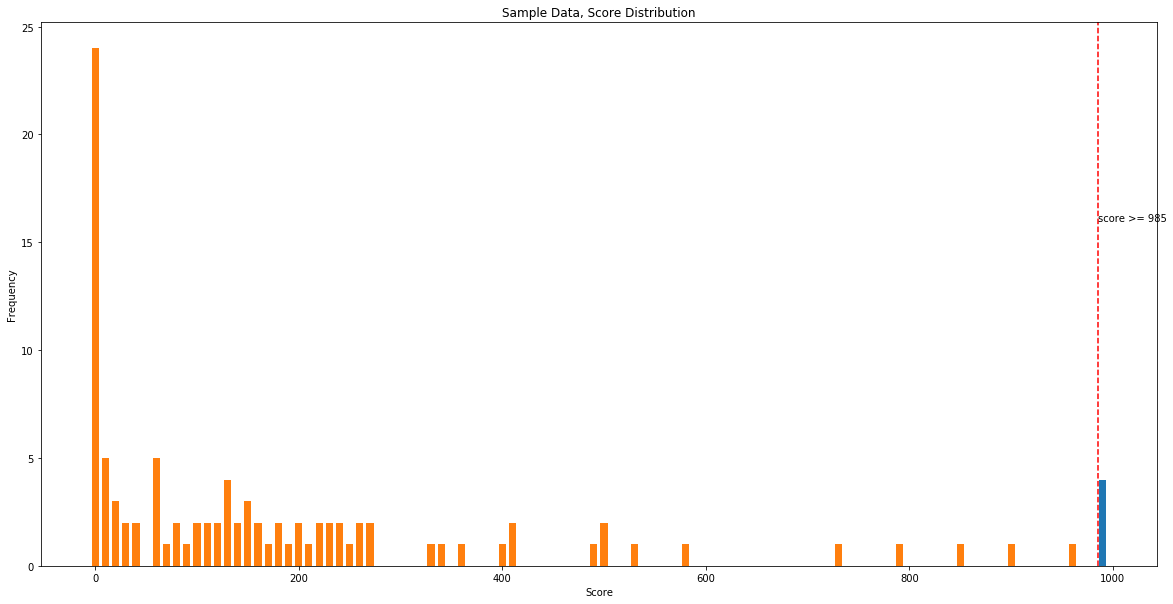

In [99]:
plot_predictions(predictions, THRESHOLD)